In [1]:
import cv2
import glob 
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
labels = glob.glob('DATA/train/*')

In [3]:
labels = [el[11:] for el in labels]

In [4]:
#определим имена классов
labels

['dancing charleston',
 'dancing gangnam style',
 'dancing ballet',
 'tango dancing']

# Data prep

In [ ]:
def read_img(path):
    cap = cv2.VideoCapture(path)
    imgs_list = []
    i = 0
    while cap.isOpened():
        ret, img = cap.read()
        if ret == True:
            imgs_list.append(cv2.resize(img, (64, 64), interpolation=cv2.INTER_LINEAR))
        else: 
            break
    imgs_list = np.asarray(imgs_list)[np.linspace(0, len(imgs_list)-1, 10).astype(np.int8)]
    return imgs_list

In [ ]:
def prepare_dataset(labels, train = True):
    images = []
    labels_list = []
    for label in labels:
        print('Label = ', label)
        if train:
            paths = glob.glob('Data/train/'+label+'/*.mp4')
        else:
            paths = glob.glob('Data/val/'+label+'/*.mp4')
        for path in tqdm(paths):
            img = read_img(path)
            if len(img) == 10:
                images.append(img)
                labels_list.append(labels.index(label))
            else:
                print("Expected len 10 but got len {} at path: ".format(len(img)), path)
    return np.asarray(images), np.asarray(labels_list)

In [7]:
train_vid, train_lab = prepare_dataset(labels, train = True)

Label =  dancing charleston


100%|█████████████████████████████████████████| 937/937 [02:00<00:00,  7.76it/s]


Label =  dancing gangnam style


100%|█████████████████████████████████████████| 969/969 [02:05<00:00,  7.74it/s]


Label =  dancing ballet


100%|█████████████████████████████████████████| 934/934 [02:04<00:00,  7.53it/s]


Label =  tango dancing


100%|█████████████████████████████████████████| 927/927 [02:27<00:00,  6.28it/s]


In [31]:
test_vid, test_lab = prepare_dataset(labels, train = False)

Label =  dancing charleston


100%|███████████████████████████████████████████| 48/48 [00:06<00:00,  6.93it/s]


Label =  dancing gangnam style


100%|███████████████████████████████████████████| 46/46 [00:05<00:00,  7.82it/s]


Label =  dancing ballet


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.86it/s]


Label =  tango dancing


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  6.23it/s]


# Exp 1 
## CNN по одному кадру

Обучим модель, которая будет определять класс видео по одному отдельному изображению

In [30]:
import torch
import torchvision
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, f1_score
torch.manual_seed(0)

In [31]:
device = torch.device("mps")

In [11]:
ed_test_lab = []
for el in test_lab:
    ed_test_lab.append([el for _ in range(10)])
ed_test_lab = np.asarray(ed_test_lab, dtype=np.float32).reshape(194*10)

In [12]:
ed_train_lab = []
for el in train_lab:
    ed_train_lab.append([el for _ in range(10)])
ed_train_lab = np.asarray(ed_train_lab, dtype=np.float32).reshape(len(ed_train_lab)*10)

In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, imgs, labels, transform=None, target_transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [14]:
dataset_train = CustomImageDataset(train_vid.reshape(len(train_vid)*10, 64, 64, 3), ed_train_lab)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=256, 
                                           shuffle=True)

In [15]:
dataset_test = CustomImageDataset(test_vid.reshape(len(test_vid)*10, 64, 64, 3), ed_test_lab)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=256, 
                                           shuffle=True)

In [54]:
#model
# модель с предобученным бэкбоном VGG16
class VGG16_bn(torch.nn.Module):
    def __init__(self):
        super(VGG16_bn, self).__init__()
        self.vgg16_backbone = torchvision.models.vgg16_bn(weights='DEFAULT').features
        self.flatten = torch.nn.Flatten()
        self.classif = torch.nn.Sequential(
            torch.nn.Linear(2048, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(256, 4),
            torch.nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.vgg16_backbone(x)
        x = self.flatten(x)
        x = self.classif(x)
        return x

In [40]:
model_base = VGG16_bn()
model_base.to(device)

VGG16_bn(
  (vgg16_backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv

In [41]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_base.parameters(), lr=0.0005)

Добавим аугментации "на лету"

In [43]:
def rotation_pts_tf(img, rotation='180'):
    image = img.numpy()
    if rotation == '180':
        image = cv2.rotate(image, cv2.ROTATE_180)
    if rotation == '-90':
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    if rotation =='+90':
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    return torch.from_numpy(image)

def batch_augmentation(images):
    # get idxs for img augmentation
    aug_idxs = np.argwhere(np.random.randint(3, size=len(images))==2).reshape(-1)
    aug_types = ['180', '-90', '+90']

    for el in aug_idxs:
        images[el] = rotation_pts_tf(images[el], rotation=aug_types[np.random.randint(3)])
    return images

In [44]:
#Train loop
print("Start training")
loss_hist = []
val_loss_hist = []
patience = 0

for epoch in range(8):
    model_base.train(True)
    running_loss = 0.0
    iters = 0
    train_acc = 0
    train_f1 = 0
    print('_____________________')
    print('EPOCH: ', epoch+1)
    for i, (img, label) in enumerate(tqdm(train_loader)):
        img = batch_augmentation(img)
        img = img.moveaxis(-1, 1)/255
        optimizer.zero_grad()

        res = model_base.forward(img.to(device))
        loss = criterion(res, label.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        iters += 1
        train_acc += accuracy_score(label, res.cpu().argmax(dim=1))
        train_f1 += f1_score(label, res.cpu().argmax(dim=1), average='weighted')
    loss_hist.append(running_loss/iters)
    train_acc = train_acc/iters
    train_f1 = train_f1/iters
    
    #show results per epoch
    print('train_loss = ', running_loss/iters)
    print(f'Train: accuracy = {train_acc}, F1 = {train_f1}')

    #validating
    running_loss = 0.0
    iters = 0
    test_acc = 0
    test_f1 = 0
    model_base.eval()
    with torch.no_grad():
        for i ,(test_img, test_label) in enumerate(test_loader, 0):
            test_img = test_img.moveaxis(-1, 1)/255
            val_res = model_base.forward(test_img.to(device))
            val_loss = criterion(val_res, test_label.to(device))
            running_loss += val_loss.item()
            iters += 1
            test_acc += accuracy_score(test_label, val_res.cpu().argmax(dim=1))
            test_f1 += f1_score(test_label, val_res.cpu().argmax(dim=1), average='weighted')
        val_loss_hist.append(running_loss/iters)
        test_acc = test_acc/iters
        test_f1 = test_f1/iters
        
    #show val results per epoch   
    print('val_loss = ', running_loss/iters)
    print(f'Test: accuracy = {test_acc}, F1 = {test_f1}')
    print('\n')

    #early stop
    if epoch > 3:
        if val_loss_hist[-1] > val_loss_hist[-2]:
            patience += 1
        else:
            patience = 0
    if patience == 4:
        break
print('Finish! Num epochs: ', epoch+1)

Start training
_____________________
EPOCH:  1


100%|█████████████████████████████████████████| 148/148 [05:04<00:00,  2.06s/it]


train_loss =  1.1540615743881948
Train: accuracy = 0.5821020959281651, F1 = 0.5710418433750651
val_loss =  1.2371476590633392
Test: accuracy = 0.49658203125, F1 = 0.4662692328352529


_____________________
EPOCH:  2


100%|█████████████████████████████████████████| 148/148 [05:03<00:00,  2.05s/it]


train_loss =  1.098100311047322
Train: accuracy = 0.6386968794452347, F1 = 0.6349320978237172
val_loss =  1.1699497252702713
Test: accuracy = 0.5657200168918919, F1 = 0.5601555818340062


_____________________
EPOCH:  3


100%|█████████████████████████████████████████| 148/148 [05:19<00:00,  2.16s/it]


train_loss =  1.073721099544216
Train: accuracy = 0.6627455992176386, F1 = 0.6605387931478697
val_loss =  1.1407798677682877
Test: accuracy = 0.5881281672297297, F1 = 0.5853084528869057


_____________________
EPOCH:  4


100%|█████████████████████████████████████████| 148/148 [05:32<00:00,  2.25s/it]


train_loss =  1.0331347906911694
Train: accuracy = 0.7043988375711238, F1 = 0.7028473830113103
val_loss =  1.1520399898290634
Test: accuracy = 0.5791147592905406, F1 = 0.5689799334426204


_____________________
EPOCH:  5


100%|█████████████████████████████████████████| 148/148 [05:23<00:00,  2.18s/it]


train_loss =  1.0200409381776243
Train: accuracy = 0.7180401515825036, F1 = 0.7168908740007272
val_loss =  1.1065541207790375
Test: accuracy = 0.6231128589527027, F1 = 0.6260938377033216


_____________________
EPOCH:  6


100%|█████████████████████████████████████████| 148/148 [05:11<00:00,  2.11s/it]


train_loss =  0.9946901826439677
Train: accuracy = 0.7437016580725462, F1 = 0.7432297821707832
val_loss =  1.1589162051677704
Test: accuracy = 0.5744035050675675, F1 = 0.5653777762853396


_____________________
EPOCH:  7


100%|█████████████████████████████████████████| 148/148 [05:09<00:00,  2.09s/it]


train_loss =  0.995086786312026
Train: accuracy = 0.7442086926564723, F1 = 0.7433484380218894
val_loss =  1.1581428796052933
Test: accuracy = 0.5769108952702703, F1 = 0.5703290129373303


_____________________
EPOCH:  8


100%|█████████████████████████████████████████| 148/148 [05:09<00:00,  2.09s/it]


train_loss =  0.9893617819289904
Train: accuracy = 0.7498777560455192, F1 = 0.7493718536478919
val_loss =  1.1196449100971222
Test: accuracy = 0.6146669130067568, F1 = 0.6117995443460864


Finish! Num epochs:  8


In [45]:
model_base.cpu()

VGG16_bn(
  (vgg16_backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv

In [46]:
torch.save(model_base, 'models/base_model.pth')

Прогоним получаемые эмбеддинги через LSTM модель для анализа последовательности

In [55]:
class CustomVideoDataset(Dataset):
    def __init__(self, labels, transform=None, target_transform=None, train_flag = True):
        self.labels = labels
        if train_flag:
            self.paths = glob.glob('Data/train/*/*.mp4')
        else:
            self.paths = glob.glob('Data/val/*/*.mp4')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        image = self.read_img(self.paths[idx])/255
        for i in range(len(self.labels)):
            if self.labels[i] in self.paths[idx]:
                label = i
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return np.moveaxis(image, -1, 1), label

    def read_img(self, path):
        cap = cv2.VideoCapture(path)
        imgs_list = []
        i = 0
        while cap.isOpened():
            ret, img = cap.read()
            if ret == True:
                imgs_list.append(cv2.resize(img, (64, 64), interpolation=cv2.INTER_LINEAR))
            else: 
                break
        imgs_list = np.asarray(imgs_list)[np.linspace(0, len(imgs_list)-1, 10).astype(np.int8)]
        return imgs_list

In [56]:
test_ds = CustomVideoDataset(labels, train_flag=False)
train_ds = CustomVideoDataset(labels)

In [57]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, 
                                          shuffle=False)

In [58]:
model_base = VGG16_bn()
model_base = torch.load('models/base_model.pth')

In [59]:
embs_preparing = model_base.vgg16_backbone.float()

In [60]:
class GRU_embs(torch.nn.Module):
    def __init__(self):
        super(GRU_embs, self).__init__()
        #self.lstm1 = torch.nn.LSTM(2048, 32)
        self.lstm1 = torch.nn.GRU(2048, 32)
        self.lstm2 = torch.nn.GRU(32, 32)
        self.dropout = torch.nn.Dropout(p = 0.4)
        self.lin1 = torch.nn.Linear(32*10, 4)
        self.softmax1 = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x, hn = self.lstm1(x)
        x, _ = self.lstm2(x, hn)
        x = self.dropout(x.view(len(x), -1))
        #x = self.lin1(x.view(len(x), -1))
        x = self.lin1(x)
        x = self.softmax1(x)
        return x

In [61]:
GRU_model = GRU_embs()

In [62]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GRU_model.parameters(), lr=0.0005)

In [63]:
#Train loop
print("Start training")
loss_hist = []
val_loss_hist = []
patience = 0
GRU_model.to(device)
embs_preparing.to(device)

for epoch in range(15):
    GRU_model.train(True)
    running_loss = 0.0
    iters = 0
    train_acc = 0
    train_f1 = 0
    print('_____________________')
    print('EPOCH: ', epoch+1)
    for i, (imgs, label) in enumerate(tqdm(train_loader)):
        embs = []
        with torch.no_grad():
            for i in range(len(imgs)):
                embs.append(embs_preparing(imgs[i].float().to(device)).reshape(10, -1))
            embs = torch.stack(embs)

        optimizer.zero_grad()

        res = GRU_model(embs)
        loss = criterion(res, label.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        iters += 1
        train_acc += accuracy_score(label, res.cpu().argmax(dim=1))
        train_f1 += f1_score(label, res.cpu().argmax(dim=1), average='weighted')
    loss_hist.append(running_loss/iters)
    train_acc = train_acc/iters
    train_f1 = train_f1/iters
    
    #show results per epoch
    print('train_loss = ', running_loss/iters)
    print(f'Train: accuracy = {train_acc}, F1 = {train_f1}')

    #validating
    running_loss = 0.0
    iters = 0
    test_acc = 0
    test_f1 = 0
    GRU_model.eval()
    with torch.no_grad():
        for i ,(test_imgs, test_label) in enumerate(test_loader, 0):
            embs = []
            for i in range(len(test_imgs)):
                embs.append(embs_preparing(test_imgs[i].float().to(device)).reshape(10, -1))
            embs = torch.stack(embs)
            
            val_res = GRU_model.forward(embs)
            val_loss = criterion(val_res, test_label.to(device))
            running_loss += val_loss.item()
            iters += 1
            test_acc += accuracy_score(test_label, val_res.cpu().argmax(dim=1))
            test_f1 += f1_score(test_label, val_res.cpu().argmax(dim=1), average='weighted')
        val_loss_hist.append(running_loss/iters)
        test_acc = test_acc/iters
        test_f1 = test_f1/iters
        
    #show val results per epoch   
    print('val_loss = ', running_loss/iters)
    print(f'Test: accuracy = {test_acc}, F1 = {test_f1}')
    print('\n')

    #early stop
    if epoch > 3:
        if val_loss_hist[-1] > val_loss_hist[-2]:
            patience += 1
        else:
            patience = 0
    if patience == 4:
        break

    #save best model
    if epoch == 0:
        best_f1 = test_f1
    else:
        if test_f1 > best_f1:
            best_f1 = test_f1
            torch.save(GRU_model, 'models/GRU_model_best.pth')
print('Finish! Num epochs: ', epoch+1)

Start training
_____________________
EPOCH:  1


100%|█████████████████████████████████████████| 118/118 [11:22<00:00,  5.78s/it]


train_loss =  1.0523299564749509
Train: accuracy = 0.7846467391304347, F1 = 0.7797366795264237
val_loss =  1.1312241213662284
Test: accuracy = 0.6071428571428571, F1 = 0.6913141358749687


_____________________
EPOCH:  2


100%|█████████████████████████████████████████| 118/118 [12:03<00:00,  6.13s/it]


train_loss =  0.8490417756266513
Train: accuracy = 0.9034520081061164, F1 = 0.9039174446297716
val_loss =  1.1479709148406982
Test: accuracy = 0.5848214285714286, F1 = 0.6726317803623186


_____________________
EPOCH:  3


100%|█████████████████████████████████████████| 118/118 [12:16<00:00,  6.24s/it]


train_loss =  0.8427146147873442
Train: accuracy = 0.9027611459100957, F1 = 0.9028126043139104
val_loss =  1.1480816006660461
Test: accuracy = 0.5848214285714286, F1 = 0.6717823789735843


_____________________
EPOCH:  4


100%|█████████████████████████████████████████| 118/118 [12:49<00:00,  6.52s/it]


train_loss =  0.8383594675589416
Train: accuracy = 0.9066299742078113, F1 = 0.9066186431148097
val_loss =  1.1333146861621313
Test: accuracy = 0.5892857142857143, F1 = 0.6774311573700303


_____________________
EPOCH:  5


100%|██████████████████████████████████████| 118/118 [6:56:11<00:00, 211.62s/it]


train_loss =  0.8366055018821005
Train: accuracy = 0.9081613854089905, F1 = 0.9083004305994872
val_loss =  1.1494989054543632
Test: accuracy = 0.5803571428571429, F1 = 0.671722671511743


_____________________
EPOCH:  6


100%|█████████████████████████████████████████| 118/118 [12:14<00:00,  6.22s/it]


train_loss =  0.836332082243289
Train: accuracy = 0.9074705232129698, F1 = 0.9077417186182605
val_loss =  1.1441818220274789
Test: accuracy = 0.5803571428571429, F1 = 0.6708616519678092


_____________________
EPOCH:  7


100%|█████████████████████████████████████████| 118/118 [11:51<00:00,  6.03s/it]


train_loss =  0.8330186751939482
Train: accuracy = 0.9110745210022108, F1 = 0.9111578987260835
val_loss =  1.1359629120145525
Test: accuracy = 0.5848214285714286, F1 = 0.676184375221567


_____________________
EPOCH:  8


100%|█████████████████████████████████████████| 118/118 [12:03<00:00,  6.14s/it]


train_loss =  0.8329216216580343
Train: accuracy = 0.9122374723655122, F1 = 0.9122165249200526
val_loss =  1.1367366654532296
Test: accuracy = 0.6071428571428571, F1 = 0.6915451691498168


_____________________
EPOCH:  9


100%|█████████████████████████████████████████| 118/118 [13:32<00:00,  6.89s/it]


train_loss =  0.8317340016365051
Train: accuracy = 0.9126635040530583, F1 = 0.9126865971844063
val_loss =  1.1217375142233712
Test: accuracy = 0.59375, F1 = 0.6827941440794406


_____________________
EPOCH:  10


100%|█████████████████████████████████████████| 118/118 [14:24<00:00,  7.32s/it]


train_loss =  0.8303774140648923
Train: accuracy = 0.9126059322033898, F1 = 0.9130540420867949
val_loss =  1.1389447280338831
Test: accuracy = 0.5892857142857143, F1 = 0.6781236007259831


_____________________
EPOCH:  11


100%|█████████████████████████████████████████| 118/118 [14:34<00:00,  7.41s/it]


train_loss =  0.827240475658643
Train: accuracy = 0.9191230655858512, F1 = 0.9193556142801709
val_loss =  1.1482185976845878
Test: accuracy = 0.5803571428571429, F1 = 0.671050529888663


_____________________
EPOCH:  12


100%|█████████████████████████████████████████| 118/118 [14:03<00:00,  7.15s/it]


train_loss =  0.827394220283476
Train: accuracy = 0.9184897752394989, F1 = 0.9187046323797291
val_loss =  1.1478118470736913
Test: accuracy = 0.5803571428571429, F1 = 0.6704029510430863


_____________________
EPOCH:  13


100%|█████████████████████████████████████████| 118/118 [13:50<00:00,  7.04s/it]


train_loss =  0.8261132103911901
Train: accuracy = 0.9187546057479735, F1 = 0.918464745783942
val_loss =  1.1350814700126648
Test: accuracy = 0.5848214285714286, F1 = 0.6746071172094996


_____________________
EPOCH:  14


100%|█████████████████████████████████████████| 118/118 [13:44<00:00,  6.98s/it]


train_loss =  0.826208154528828
Train: accuracy = 0.9172231945467944, F1 = 0.917645700738698
val_loss =  1.1515437364578247
Test: accuracy = 0.5848214285714286, F1 = 0.6763684757122713


_____________________
EPOCH:  15


100%|█████████████████████████████████████████| 118/118 [13:39<00:00,  6.94s/it]


train_loss =  0.8241910762706045
Train: accuracy = 0.9203435887988209, F1 = 0.9202186116055487
val_loss =  1.1542521800313676
Test: accuracy = 0.5803571428571429, F1 = 0.6722735675211283


Finish! Num epochs:  15


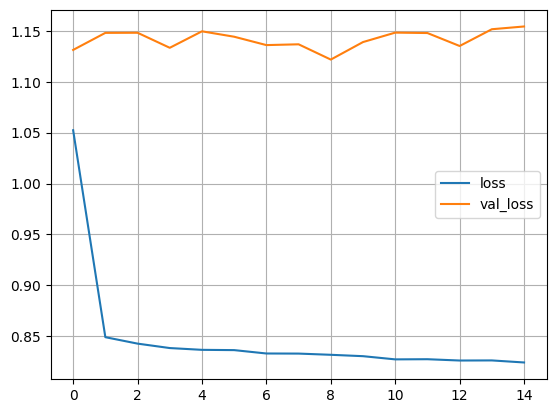

In [64]:
# Графики функции потерь для LSTM модели
plt.plot(loss_hist, label='loss')
plt.plot(val_loss_hist, label='val_loss')
plt.grid()
plt.legend()